# 3.1 MNIST

- 사이킷런을 이용하여 데이터셋 내려받기

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [46]:
# 깔끔한 그래프 출력을 위해
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

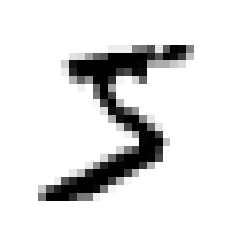

In [47]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np

y = y.astype(np.uint8)

- 훈련 세트와 테스트 세트 분리(이미 앞의 60,000개와 뒤의 10,000개로 나위어 있음)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

---

# 3.2 이진 분류기 훈련

- 10 개의 숫자 중 5만 구분할 수 있도록 구현(5와 5가 아닌 숫자, 두 개의 클래스로 분류)

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- SGDClassifier 클래스를 이용하여 확률적 경사 하강법<sup>Stochastic Gradient Descent</sup>(SGD)분류기 사용
- 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있음

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
# 훈련
sgd_clf.fit(X_train, y_train_5)
# 예측
sgd_clf.predict([some_digit])

array([ True])

---

# 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

- 직접 구현한 교차 검증 기능

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- 사이킷런의 cross_val_score()를 이용한 평가

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 이미지에 대해 5 아닌 숫자에 대한 이진 분류기 만들기

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도를 성능 지표로 삼는 것은 좋지 않다(특히 불균형한 데이터셋에서).

### 3.3.2 오차 행렬

- 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬<sup>confusion matrix</sup>를 조사하는 것
- cross_val_predict()로 예측을 만든다.
- cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수가 아닌 각 테스트 폴드에서 얻은 예측을 반환한다.
- confusion_matrix() 함수로 오차 행렬 생성
- 오차 행렬의 행은 실제 클래스를, 열은 예측한 클래스를 의미

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

> 5 아님 이미지에 대해 53892 건을 정확하게 분류, 687건을 잘못 분류  
> 5 이미지에 대해 1891 건을 5 아님으로 잘못 분류, 3530건을 5로 정확하게 분류함

In [17]:
# 환벽하게 분류한 경우의 오차 행렬의 형태
y_train_perfect_prediction = y_train_5

confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

> **분류기의 정밀도(양성 예측의 정확도)**  
> $ 정밀도 = \frac{TP}{TP + FP} $  
> TP: 진짜 양성의 수, FP: 거짓 양성의 수

- 정밀도는 재현율<sup>recall</sup>과 함께 사용하는 것이 일반적

> **뷴류기의 재현률(민감도<sup>sensitivity</sup>, 진짜 양성 비율<sup>true positive rate</sup>(TPR))**  
> $ 재현율 = \frac{TP}{TP + FN} $  
> FP: 거짓 음성의 수

| TN(진짜 음성) | FP(거짓 양성) |
|---|---|
| FN(거짓 음성) | TP(진짜 양성) |

### 3.3.3 정밀도와 재현율

- 사이킷런에서 사용되는 함수들

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

> **F<sub>1</sub> 점수<sup>F<sub>1</sub> score</sup>**  
> 정밀도와 재현율의 조화 평균<sup>harmonic mean</sup>  
> $ F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP + \frac{FN + FP}{2}} $

- f1_score() 함수를 이용하여 F<sub>1</sub> 점수 계산
- 상황에 따라 정밀도와 재현율은 트레이트오프가 있다.

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

- SGDClassifier는 결정 함수<sup>decision function</sup>를 사용하여 각 샘플의 점수를 계산함며, 점수가 임곗값보다 크면 샘플을 양성 클래스로, 그렇지 않으면 음성 클래스로 할당한다.
- 이 임곗값을 높이면 정밀도는 높아지나 재현율이 낮아지고, 낮추면 정밀도는 낮아지고 재현율이 높아진다.
- 사이킷런에서 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있으며 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.
- 적절한 임곗값을 정하기 위해서는 cross_val_predict() 함수를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
- precision_recall_curve() 함수를 이용하여 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산할 수 있다.

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
# 임곗값
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
# 결정 젘수를 반환받도록 지정한 코드
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
# 모든 임곗값에 대한 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


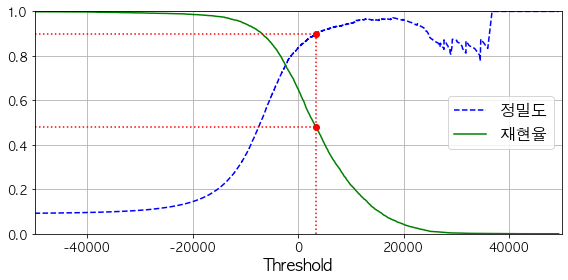

In [48]:
# 임곗값의 함수로 정밀도와 재현율 그리기
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'AppleGothic'

def plot_precision_recall_vs_threshold(predicions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

그림 저장: precision_vs_recall_plot


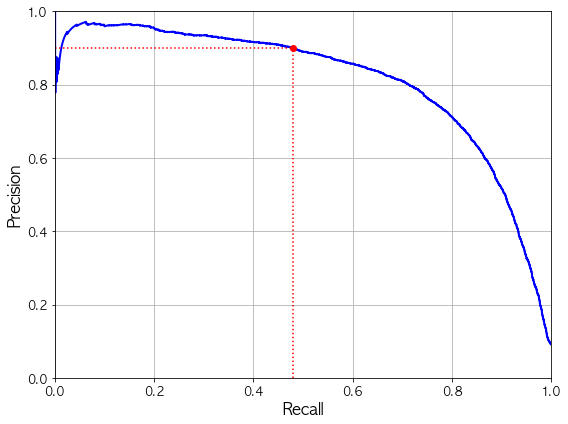

In [49]:
# 재현율에 대한 정밀도 곡선 그리기

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

- 그래프상 재현율 80% 근처에서 정밀도가 급격히 줄어드는데 이 직전 값을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.
- 목표 정밀도를 결정하기 전에 반드시 기준이 되는 최저 재현율을 결정해야 한다.

In [50]:
# 훈련 세트에 대한 예측을 만드는 코드
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
# 위 예측에 대한 정밀도와 재현율
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선